In [1]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm as _tqdm
import gym
import argparse
import copy
from gridworld import GridworldEnv
from tqdm import tqdm
import pickle
import itertools

from contextlib import contextmanager
import sys, os

from DQN_model import QNetwork
from DQN_replay import ReplayMemory
from DQN_policy import EpsilonGreedyPolicy, get_epsilon
from DQN_training import train
from DQN_plots import plot_smooth
from DQN_main import run_episodes

In [2]:
# From https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python
@contextmanager
def suppress_stdout(suppress):
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        if suppress:
            sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
listi = [1, 2, 3]
# print(itertools.cycle(listi)[4])

In [63]:
def plot_with_error(losses, unc=True, filename=None, plot_label="Loss", y_label="Loss", colour='blue',
                    fig_in=None, red_line=None):
    losses = np.array(losses)

    means = np.mean(losses, axis=0)
    errors = np.std(losses, axis=0)
    
    if unc: # Plot uncertainty instead of std
        errors = errors / np.sqrt(losses.shape[0])
    
    x = np.arange(len(means))
    if fig_in is None:
        fig, ax = plt.subplots(1)
        if red_line is not None:
            plt.axhline(y=red_line, color='r', linestyle='-')
    else:
        fig, ax = fig_in
    ax.plot(x, means, lw=2, label=f"Mean {plot_label}", color=colour)
    ax.fill_between(x, means+errors, means-errors, facecolor=colour, alpha=0.5)
    if fig_in is None:
        ax.legend(loc='upper left', fancybox=True)
    ax.set_xlabel('Episodes')
    ax.set_ylabel(y_label)
    
    
    
    ax.grid()
    if fig_in is not None:
        return fig, ax
    if filename is not None:
        save_path = '../plots/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
                
        plt.savefig(f"{save_path}/{filename}.pdf", format='pdf')
        
def plot_multiple(multiple_losses, labels, filename=None, y_label="Loss",
                  red_line=None, br=False, legend_off=False): # Assumes multiple losses contains a set of loss_list's for each parameter
    # File prepends should be a list of names
    colours = ['b', 'g', 'y', 'm', 'c', 'k', 'w']
    fig, ax = plt.subplots()
    if red_line is not None:
        plt.axhline(y=red_line, color='r', linestyle='-')
    for (losses, colour, label) in zip(multiple_losses, colours, labels):
        plot_with_error(losses, unc=True, plot_label=label, y_label=y_label, colour=colour,
                        fig_in = (fig,ax), red_line=red_line)
    
    ax.grid()
    if br and not legend_off:
        ax.legend(loc='lower right', fancybox=True)
    elif not legend_off:
        ax.legend(loc='upper left', fancybox=True)
    if filename is not None:
        save_path = '../plots/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
                
        plt.savefig(f"{save_path}/{filename}.pdf", format='pdf')
    
    

In [4]:
def pickle_tuple(tupl, filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'wb') as f:
        pickle.dump(tupl,f)

def unpickle_tuple(filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'rb') as f:
        return pickle.load(f)

In [7]:
def run_setting(env_name, num_episodes, batch_size, memory_size, discount_factor, learn_rate, seed, num_hidden, 
                min_eps, max_eps, anneal_time, clone_interval, clipping, suppress_printing):
    # mostly copied from main() in DQN_main.py, removed some code for overview
    # if you want replay to be turned off, use batch_size=memory_size=1
    # returns episode durations (list), losses averaged per step (list), max abs q averaged per step (list)
    
    env = GridworldEnv() if env_name == "GridWorldEnv" else gym.make(env_name)

    obs_shape = env.observation_space.shape
    num_actions = env.action_space.n
    if env_name == "Blackjack-v0":
        obs_size = 3
    elif len(obs_shape) > 0: 
        obs_size = obs_shape[0]
    else:
        obs_size = 1
#     obs_size = obs_shape[0] if len(obs_shape) > 0 else 1

    memory = ReplayMemory(memory_size)

    # for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    Q_net = QNetwork(obs_size, num_actions, num_hidden=num_hidden)
    policy = EpsilonGreedyPolicy(Q_net, num_actions)
    with suppress_stdout(suppress_printing):
        return run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, 
                            learn_rate, clone_interval, min_eps, max_eps, anneal_time, clipping)

In [ ]:
# Replay OFF, Target Network OFF
settings = {
    'env_name':"CartPole-v1",
    'num_episodes':1000,
    'batch_size':1, 
    'memory_size':1, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':None, 
    'clipping':True,
    'suppress_printing':True
}

durations_list_rF_tF, losses_list_rF_tF, max_Qs_list_rF_tF = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    durations_list_rF_tF.append(durations)
    losses_list_rF_tF.append(losses)
    max_Qs_list_rF_tF.append(max_Qs)
filename = f"CartPole-v1_{seed}_replay_off"
pickle_tuple((durations_list_rF_tF, losses_list_rF_tF, max_Qs_list_rF_tF, settings), filename=filename)

In [ ]:
# Replay ON, Target Network OFF
settings = {
    'env_name':"CartPole-v1",
    'num_episodes':1000,
    'batch_size':64, 
    'memory_size':50000, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':None, 
    'clipping':True,
    'suppress_printing':True
}

durations_list_rT_tF, losses_list_rT_tF, max_Qs_list_rT_tF = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    durations_list_rT_tF.append(durations)
    losses_list_rT_tF.append(losses)
    max_Qs_list_rT_tF.append(max_Qs)
filename = f"CartPole-v1_{seed}_replay_on"
pickle_tuple((durations_list_rT_tF, losses_list_rT_tF, max_Qs_list_rT_tF, settings), filename=filename)

In [ ]:
# Plot for replay ON/OFF, no saving
plot_multiple([losses_list_rF_tF, losses_list_rT_tF], labels=["Loss for Replay OFF", "Loss for Replay ON"], 
              filename=None)

discount_factor = settings['discount_factor']
line_level = 1./(1-discount_factor)

plot_multiple([max_Qs_list_rF_tF, max_Qs_list_rT_tF], labels=["Max|Q| for Replay OFF", "Max|Q| for Replay ON"], 
              y_label='Max |Q|', red_line=line_level, filename=None)

In [ ]:
# # Plot for replay ON/OFF
# plot_multiple([losses_list_rF_tF, losses_list_rT_tF], labels=["Loss for Replay OFF", "Loss for Replay ON"], 
#               filename="Loss_ReplayONOFF")

# discount_factor = settings['discount_factor']
# line_level = 1./(1-discount_factor)

# plot_multiple([max_Qs_list_rF_tF, max_Qs_list_rT_tF], labels=["Max|Q| for Replay OFF", "Max|Q| for Replay ON"], 
#               y_label='Max |Q|', red_line=line_level, filename="MaxQ_ReplayONOFF")

In [ ]:
# Replay OFF, Target Network ON
settings = {
    'env_name':"CartPole-v1",
    'num_episodes':1000,
    'batch_size':1, 
    'memory_size':1, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':500, 
    'clipping':True,
    'suppress_printing':True
}

durations_list_rF_tT, losses_list_rF_tT, max_Qs_list_rF_tT = [], [], []
for seed in tqdm([1]):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    durations_list_rF_tT.append(durations)
    losses_list_rF_tT.append(losses)
    max_Qs_list_rF_tT.append(max_Qs)
filename = f"CartPole-v1_{seed}_replay_on_tn_on"
pickle_tuple((durations_list_rF_tT, losses_list_rF_tT, max_Qs_list_rF_tT, settings), filename=filename)

In [ ]:
# Plot with target network ON/OFF, no saving
plot_multiple([losses_list_rF_tF, losses_list_rF_tT], labels=["Loss for TN OFF", "Loss for TN ON"]
             , filename=None)

discount_factor = settings['discount_factor']
line_level = 1./(1-discount_factor)

plot_multiple([max_Qs_list_rF_tF, max_Qs_list_rF_tT], labels=["Max|Q| for TN OFF", "Max|Q| for TN ON"], 
              y_label='Max |Q|', red_line=line_level, filename=None)

In [ ]:
# # Plot with target network ON/OFF
# plot_multiple([losses_list_rF_tF, losses_list_rF_tT], labels=["Loss for TN OFF", "Loss for TN ON"]
#              , filename="Loss_TNONOFF")

# discount_factor = settings['discount_factor']
# line_level = 1./(1-discount_factor)

# plot_multiple([max_Qs_list_rF_tF, max_Qs_list_rF_tT], labels=["Max|Q| for TN OFF", "Max|Q| for TN ON"], 
#               y_label='Max |Q|', red_line=line_level, filename="MaxQ_TNONOFF")

In [ ]:
# example plot
plot_with_error(max_Qs_list_rT_tT, unc=True, filename=filename, plot_label="Max |Q|", red_line=10)
# plot_with_error(max_Qs_list, unc=True, filename=filename+"_Q", plot_label="Max Q", colour='red')
# print(len(losses_list_rF))
# plot_multiple([losses_list_rF_tF, losses_list_rT_tF], labels=["Loss for Replay OFF", "Loss for Replay ON"])
'r',
# discount_factor = settings['discount_factor']
# line_level = 1./(1-discount_factor)

# plot_multiple([max_Qs_list_rF_tF, max_Qs_list_rT_tF], labels=["Max|Q| for Replay OFF", "Max|Q| for Replay ON"], 
#               y_label='Max |Q|', red_line=line_level)

In [22]:
# # ACROBOT: Replay OFF, Target Network OFF
# settings = {
#     'env_name':"Acrobot-v1",
#     'num_episodes':100,
#     'batch_size':1, 
#     'memory_size':1, 
#     'discount_factor':0.8, 
#     'learn_rate':1e-3, 
#     'num_hidden':128, 
#     'min_eps':0.05, 
#     'max_eps':1., 
#     'anneal_time':1000, 
#     'clone_interval':None, 
#     'clipping':True,
#     'suppress_printing':True
# }

# Bj_durations_list_rF_tF, Bj_losses_list_rF_tF, Bj_max_Qs_list_rF_tF = [], [], []
# for seed in tqdm(range(1,11)):
#     durations, losses, max_Qs = run_setting(**settings, seed=seed)
#     Bj_durations_list_rF_tF.append(durations)
#     Bj_losses_list_rF_tF.append(losses)
#     Bj_max_Qs_list_rF_tF.append(max_Qs)
# filename = f"Blackjack-v1_{seed}_replay_off_tn_off"
# pickle_tuple((Bj_durations_list_rF_tF, Bj_losses_list_rF_tF, Bj_max_Qs_list_rF_tF, settings), filename=filename)

  0%|          | 0/10 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 10%|█         | 1/10 [01:04<09:37, 64.20s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 20%|██        | 2/10 [02:08<08:33, 64.14s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 30%|███       | 3/10 [03:08<07:20, 62.95s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 40%|████      | 4/10 [04:10<06:16, 62.68s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 50%|█████     | 5/10 [05:13<05:14, 62.85s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 60%|██████    | 6/10 [06:18<04:14, 63.53s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 70%|███████   | 7/10 [07:22<03:11, 63.67s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 80%|████████  | 8/10 [08:32<02:11, 65.59s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 90%|█████████ | 9/10 [09:38<01:05, 65.65s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 10/10 [10:44<00:00, 64.41s/it]


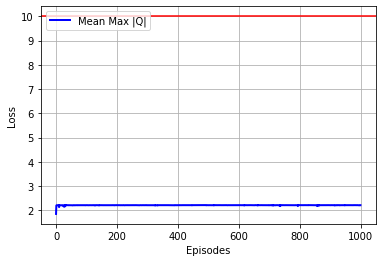

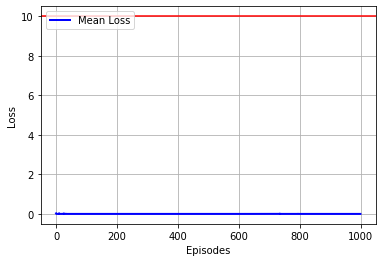

In [14]:
plot_with_error(Bj_max_Qs_list_rF_tF, unc=True, filename=filename, plot_label="Max |Q|", red_line=10)
plot_with_error(Bj_losses_list_rF_tF, unc=True, filename=filename, plot_label="Loss", red_line=10)


In [35]:
# ACROBOT: Replay ON, Target Network OFF
settings = {
    'env_name':"Acrobot-v1",
    'num_episodes':100,
    'batch_size':64, 
    'memory_size':10000, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':None, 
    'clipping':True,
    'suppress_printing':True
}

Bj_durations_list_rT_tF, Bj_losses_list_rT_tF, Bj_max_Qs_list_rT_tF = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    Bj_durations_list_rT_tF.append(durations)
    Bj_losses_list_rT_tF.append(losses)
    Bj_max_Qs_list_rT_tF.append(max_Qs)
filename = f"Acrobot-v1_{seed}_replay_on_tn_off"
pickle_tuple((Bj_durations_list_rT_tF, Bj_losses_list_rT_tF, Bj_max_Qs_list_rT_tF, settings), filename=filename)

# (Bj_durations_list_rT_tF, Bj_losses_list_rT_tF, Bj_max_Qs_list_rT_tF, settings) = \
#     unpickle_tuple(filename=f"Blackjack-v1_{seed}_replay_on_tn_off")

  0%|          | 0/10 [00:00<?, ?it/s]/home/daniel/anaconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/mnt/20E2A17CE2A15736/Users/Public/Documents/Central Documents/Education/MSc AI UvA/Courses/Reinforcement Learning/Labs/DQN-Experiments/scripts/DQN_model.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)  # Seems like this does nothing, even when numpy gets passed into Q


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 10%|█         | 1/10 [00:59<08:51, 59.05s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 20%|██        | 2/10 [01:57<07:51, 58.90s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 30%|███       | 3/10 [02:57<06:54, 59.26s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 40%|████      | 4/10 [03:51<05:45, 57.61s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 50%|█████     | 5/10 [04:52<04:52, 58.59s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 60%|██████    | 6/10 [05:45<03:48, 57.06s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 70%|███████   | 7/10 [06:42<02:51, 57.07s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 80%|████████  | 8/10 [07:38<01:53, 56.59s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 90%|█████████ | 9/10 [08:33<00:56, 56.16s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 10/10 [09:31<00:00, 57.13s/it]


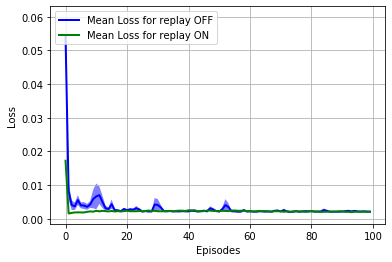

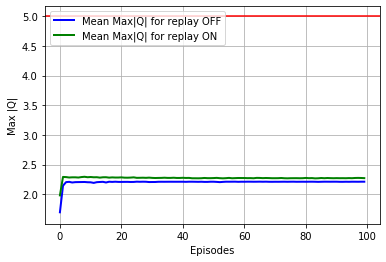

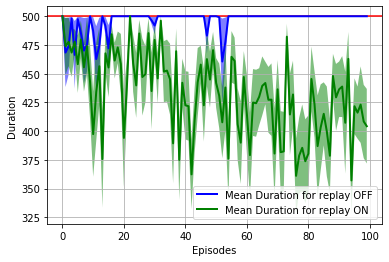

In [40]:
plot_multiple([Bj_losses_list_rF_tF, Bj_losses_list_rT_tF], labels=["Loss for replay OFF", "Loss for replay ON"]
             , filename="Acrobot_replay_test_losses")

discount_factor = settings['discount_factor']
line_level = 1./(1-discount_factor)

plot_multiple([Bj_max_Qs_list_rF_tF, Bj_max_Qs_list_rT_tF], labels=["Max|Q| for replay OFF", "Max|Q| for replay ON"], 
              y_label='Max |Q|', red_line=line_level, filename="Acrobot_replay_test_maxQ")

plot_multiple([Bj_durations_list_rF_tF, Bj_durations_list_rT_tF], labels=["Duration for replay OFF", "Duration for replay ON"], 
              y_label='Duration', red_line=500, filename="Acrobot_replay_test_dura", br=True)


In [38]:
# ACROBOT: Replay OFF, Target Network ON
settings = {
    'env_name':"Acrobot-v1",
    'num_episodes':100,
    'batch_size':1, 
    'memory_size':1, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':50000, 
    'clipping':True,
    'suppress_printing':True
}

Bj_durations_list_rF_tT, Bj_losses_list_rF_tT, Bj_max_Qs_list_rF_tT = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    Bj_durations_list_rF_tT.append(durations)
    Bj_losses_list_rF_tT.append(losses)
    Bj_max_Qs_list_rF_tT.append(max_Qs)
filename = f"Acrobot-v1_replay_off_tn_on"
pickle_tuple((Bj_durations_list_rF_tT, Bj_losses_list_rF_tT, Bj_max_Qs_list_rF_tT, settings), filename=filename)

  0%|          | 0/10 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 10%|█         | 1/10 [00:29<04:27, 29.71s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 20%|██        | 2/10 [04:40<12:47, 95.93s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 30%|███       | 3/10 [05:41<09:58, 85.47s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 40%|████      | 4/10 [06:42<07:49, 78.22s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 50%|█████     | 5/10 [07:39<05:58, 71.77s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 60%|██████    | 6/10 [08:37<04:30, 67.70s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 70%|███████   | 7/10 [09:05<02:47, 55.83s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 80%|████████  | 8/10 [09:47<01:43, 51.58s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 90%|█████████ | 9/10 [10:40<00:52, 52.09s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 10/10 [11:05<00:00, 66.54s/it]


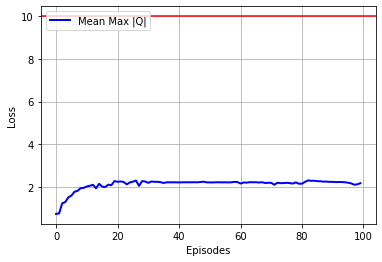

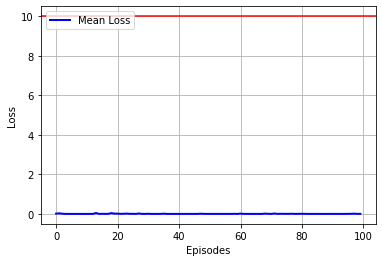

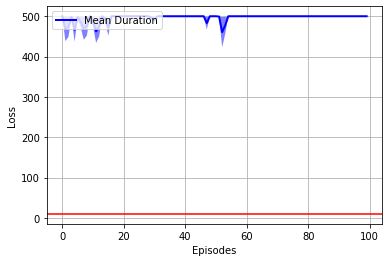

In [34]:
plot_with_error(Bj_max_Qs_list_rF_tT, unc=True, filename=filename, plot_label="Max |Q|", red_line=10)
plot_with_error(Bj_losses_list_rF_tT, unc=True, filename=filename, plot_label="Loss", red_line=10)
plot_with_error(Bj_durations_list_rF_tF, unc=True, filename=filename, plot_label="Duration", red_line=10)


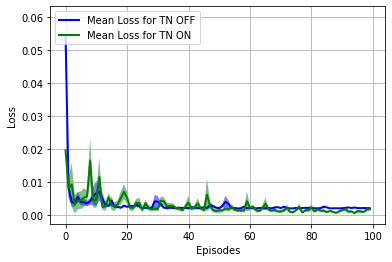

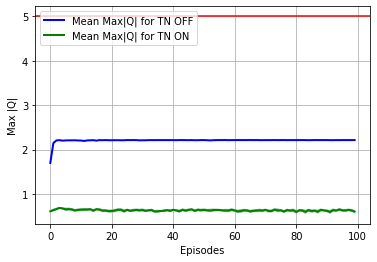

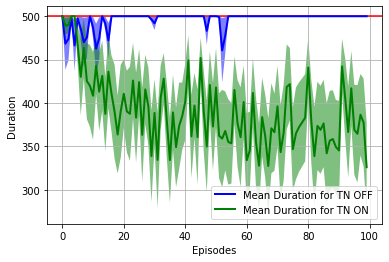

In [39]:
plot_multiple([Bj_losses_list_rF_tF, Bj_losses_list_rF_tT], labels=["Loss for TN OFF", "Loss for TN ON"]
             , filename="Acrobot_TN_test_losses")

discount_factor = settings['discount_factor']
line_level = 1./(1-discount_factor)

plot_multiple([Bj_max_Qs_list_rF_tF, Bj_max_Qs_list_rF_tT], labels=["Max|Q| for TN OFF", "Max|Q| for TN ON"], 
              y_label='Max |Q|', red_line=line_level, filename="Acrobot_TN_test_maxQ")

plot_multiple([Bj_durations_list_rF_tF, Bj_durations_list_rF_tT], labels=["Duration for TN OFF", "Duration for TN ON"], 
              y_label='Duration', red_line=500, filename="Acrobot_TN_test_dura", br=True)


In [41]:
# ACROBOT: Replay ON, Target Network ON
settings = {
    'env_name':"Acrobot-v1",
    'num_episodes':100,
    'batch_size':64, 
    'memory_size':10000, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':50000, 
    'clipping':True,
    'suppress_printing':True
}

Bj_durations_list_rT_tT, Bj_losses_list_rT_tT, Bj_max_Qs_list_rT_tT = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    Bj_durations_list_rT_tT.append(durations)
    Bj_losses_list_rT_tT.append(losses)
    Bj_max_Qs_list_rT_tT.append(max_Qs)
filename = f"Acrobot-v1_replay_on_tn_on"
pickle_tuple((Bj_durations_list_rT_tT, Bj_losses_list_rT_tT, Bj_max_Qs_list_rT_tT, settings), filename=filename)

  0%|          | 0/10 [00:00<?, ?it/s]/home/daniel/anaconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/mnt/20E2A17CE2A15736/Users/Public/Documents/Central Documents/Education/MSc AI UvA/Courses/Reinforcement Learning/Labs/DQN-Experiments/scripts/DQN_model.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)  # Seems like this does nothing, even when numpy gets passed into Q


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 10%|█         | 1/10 [00:20<03:02, 20.26s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 20%|██        | 2/10 [01:23<04:24, 33.11s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 30%|███       | 3/10 [02:04<04:07, 35.38s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 40%|████      | 4/10 [03:08<04:25, 44.19s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 50%|█████     | 5/10 [03:54<03:42, 44.56s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 60%|██████    | 6/10 [04:38<02:58, 44.63s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 70%|███████   | 7/10 [05:14<02:05, 41.94s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 80%|████████  | 8/10 [05:39<01:13, 36.85s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 90%|█████████ | 9/10 [06:18<00:37, 37.52s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 10/10 [06:34<00:00, 39.48s/it]


b
g
y
m
b
g
y
m
b
g
y
m


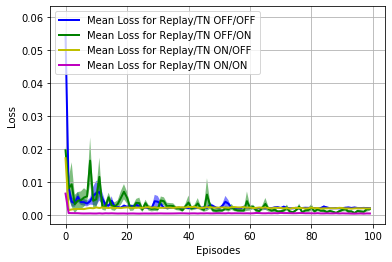

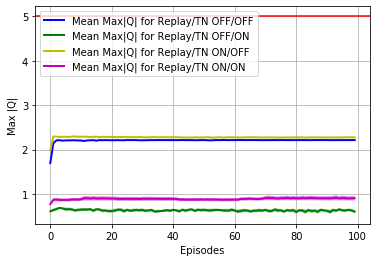

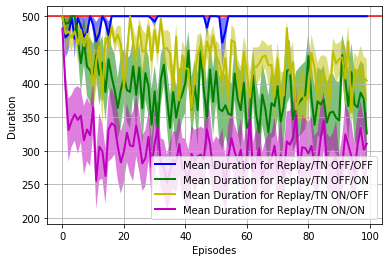

In [62]:
plot_multiple([Bj_losses_list_rF_tF, Bj_losses_list_rF_tT, Bj_losses_list_rT_tF, Bj_losses_list_rT_tT], 
              labels=["Loss for Replay/TN OFF/OFF", "Loss for Replay/TN OFF/ON",
                     "Loss for Replay/TN ON/OFF", "Loss for Replay/TN ON/ON"], 
              filename="Acrobot_full_test_losses", legend_off = False)

discount_factor = settings['discount_factor']
line_level = 1./(1-discount_factor)

plot_multiple([Bj_max_Qs_list_rF_tF, Bj_max_Qs_list_rF_tT, Bj_max_Qs_list_rT_tF, Bj_max_Qs_list_rT_tT], 
              labels=["Max|Q| for Replay/TN OFF/OFF", "Max|Q| for Replay/TN OFF/ON",
                     "Max|Q| for Replay/TN ON/OFF", "Max|Q| for Replay/TN ON/ON"], 
              filename="Acrobot_full_test_maxQ", y_label='Max |Q|', red_line=line_level, legend_off = False)

plot_multiple([Bj_durations_list_rF_tF, Bj_durations_list_rF_tT, Bj_durations_list_rT_tF, Bj_durations_list_rT_tT], 
              labels=["Duration for Replay/TN OFF/OFF", "Duration for Replay/TN OFF/ON",
                     "Duration for Replay/TN ON/OFF", "Duration for Replay/TN ON/ON"], 
              filename="Acrobot_full_test_dura", y_label='Duration', red_line=500, br=True, legend_off = False)


